In [19]:
import torch
import numpy as np
import os
from Modules.TreeLearn.TreeLearn import TreeLearn
from Modules.TreeLearn.train import run_training
from Modules.DataLoading.TreeSet import TreeSet, get_dataloader
from Modules.Utils import EarlyStopper
from timm.scheduler.cosine_lr import CosineLRScheduler
import argparse
import sys
import fastprogress
import logging

In [20]:
cwd = os.getcwd()
modelPath = os.path.join( os.path.dirname(cwd), 'ModelSaves', 'TreeLearn', 'TreeLearn_U5_V0.1_N0.1_test.pt' )

spatial_shape = [ 
        np.round( 30/0.1 ).astype(int), 
        np.round( 30/0.1 ).astype(int), 
        np.round( 50/0.1 ).astype(int) 
    ]

model = TreeLearn(dim_feat=1, use_coords=True, use_feats=True, num_blocks=5, voxel_size=0.1, spatial_shape=spatial_shape).cuda()
model.load_state_dict(torch.load( modelPath, weights_only=True ))
model.eval()

In [21]:
data = np.load( os.path.join(os.path.dirname(cwd), 'data', 'testing', 'test.npy') )
points = torch.from_numpy( data[:, :3] ).float()
# feats = torch.zeros(len(points)).float()
feats = torch.from_numpy(data[:, 6]).float().unsqueeze(1)
batch_ids = torch.zeros(len(points), dtype=torch.long)

batch = {
    "coords": points,
    "feats": feats,
    "batch_ids": batch_ids,
    "batch_size": 1,  # Only one tree
}

with torch.no_grad():
    output = model.forward(batch, return_loss=False)

offset_predictions = output["offset_predictions"].cpu().numpy()  # Shape: (N, 3)
points = points.cpu().numpy()  # Convert to NumPy for plotting

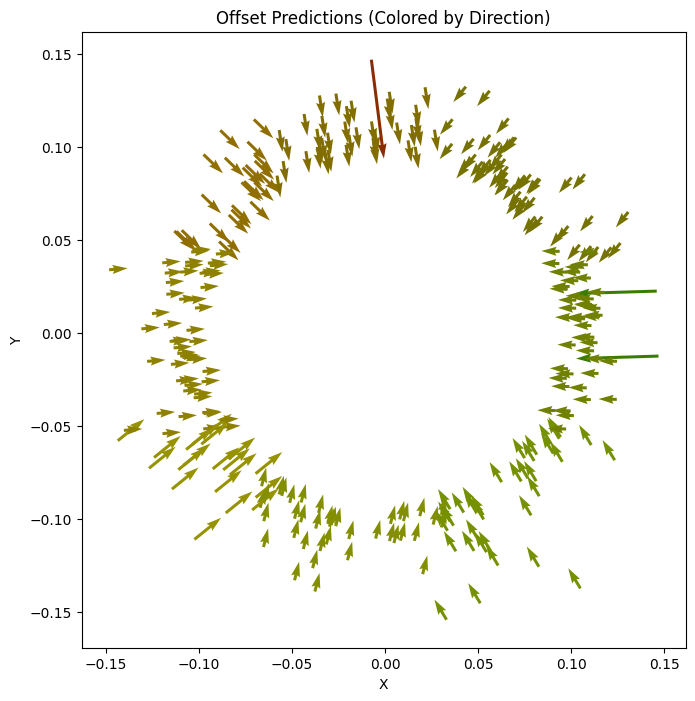

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# --- Select a slice based on Z-values ---
z_min, z_max = 0.5, 0.6  # Define slice range
mask = (points[:, 2] >= z_min) & (points[:, 2] <= z_max)
points_slice = points[mask]
offset_slice = offset_predictions[mask]
# offset_slice = data[:,3:6][mask]

# Normalize offsets for RGB colors (values between 0 and 1)
norm = Normalize(vmin=-0.08, vmax=0.08)  # Offsets in the range of [-0.2, 0.2]
colors = np.stack([
    norm(offset_slice[:, 0]),  # X -> Red channel
    norm(offset_slice[:, 1]),  # Y -> Green channel
    np.zeros(len(offset_slice))  # Z -> No color, so we set blue to 0
], axis=1)

# --- Plot using Quiver ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.quiver(
    points_slice[:, 0], points_slice[:, 1],  # Start positions (x, y)
    offset_slice[:, 0], offset_slice[:, 1],  # Vector directions (dx, dy)
    color=colors, angles='xy', scale_units='xy', scale=1, width=0.005
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Offset Predictions (Colored by Direction)")
ax.set_aspect('equal')
plt.show()